In [1]:
import time
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torch.autograd import Variable
import numpy as np
from PIL import Image
from sklearn import svm
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plot
from data.ml_dataset import BODataSet
from data.cnn_dataset import BloodOxyen
from models.tcn import TCN
from models.google_net import GoogleNet
from models.nasnet import NASNET
from models.vgg16 import vgg16
from models.dense import DenseNet
from models.resnet import ResNet
from models.psgnet import PSGNet

C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 神经网络参数
root = './data/train'
batch_size = 4
input_channels = 1
n_classes = 3
seq_length = int(90 / input_channels)
epochs = 50
steps = 0
levels = 8
nhid = 256
dropout = 0.05
channel_sizes = [nhid] * levels
kernel_size = 3
lr = 0.001
optim = "SGD"

In [3]:
# 计算F1 score 准确率 召回率
def score(Y, pre_Y):
    print("Precision_score: %.1f " % (metrics.precision_score(Y, pre_Y, average='weighted')*100))
    print("recall_score: %.1f " % (metrics.recall_score(Y, pre_Y, average='weighted')*100))
    print("f1_score: %.1f " % (metrics.f1_score(Y, pre_Y, average='weighted')*100))

In [4]:
# 加载数据
train_set = BloodOxyen(root=root, train=True, extend=False)
val_set = BloodOxyen(root=root, train=False, extend=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [5]:
train_set.class_total, len(train_set)

([101.0, 15.0, 8.0], 86)

In [6]:
# 初始化网路，verbose 参数决定运行时是否print网络规模（输入输出层数）
verbose = False
gn_model = GoogleNet(input_channels, n_classes, verbose=verbose)
na_model = NASNET(input_channels, n_classes, verbose=verbose)
vgg_model = vgg16(num_classes=3, verbose=verbose)
ds_model = DenseNet(verbose=verbose)
re_model = ResNet(3, verbose=verbose)
tcn_model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)
psg_model = PSGNet(1, 3, verbose)

C:\F\psg-machine-learning-TCN\models\google_net.py:107: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
C:\F\psg-machine-learning-TCN\models\dense.py:104: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### Tools

In [7]:
# 调整学习率函数
def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


### Training

In [8]:
# select a model and train

# some arguments for training: loss, epoch, accuracy
model = re_model
criterion = torch.nn.CrossEntropyLoss()
optimizer = getattr(torch.optim, optim)(model.parameters(), lr=lr)
classes = ('normal', 'hypopnea', 'apnea')
class_total = [0, 0, 0]
class_correct = [0, 0, 0]
train_loss = 0
best_loss = 100
best_acc = []
epochs=5

for ep in range(epochs):
    # record prediction results
    class_total = list(0. for i in range(3))
    class_correct = list(0. for i in range(3))
    train_loss = 0
    best_loss = 100
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if data.shape[0] == 1:
            continue
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # validation
    numpy_Y = np.array([])
    numpy_pred = np.array([])
    for seqs, labels in val_loader:
        output = model(seqs)
        _,prediction = torch.max(output.data, 1)
        pre = (labels == prediction.data)
        numpy_Y = np.concatenate((numpy_Y, labels.numpy()))
        numpy_pred = np.concatenate((numpy_pred, prediction.numpy()))
        for y_i in range(len(labels)):
            label = labels[y_i]
            class_total[label] += 1
            class_correct[label] += pre[y_i].item()
            
    score(numpy_Y, numpy_pred)
    adjust_learning_rate(lr, optimizer, ep)
    accs = []
    accs.append("Accuracy of network on %d events: %.1f%%" %(sum(class_total),  sum(class_correct) / sum(class_total) *100))
    accs.append("Accuracy of network on %d abevents: %.1f%%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["Accuracy on %d %s events: %.1f%%" %(class_total[i], classes[i], class_correct[i] / class_total[i] * 100) for i in range(3)])

    train_loss = train_loss/(len(train_set))
    # save the best model
    if train_loss < best_loss:
        best_loss = train_loss
        best_acc = accs
        torch.save(model.state_dict(), "./checkpoints/{}_params.pkl".format(str(model)[:3]))
        #log_model(model, optimizer, criterion, sum(class_total), best_loss, accs)
    epoch_str = ("Epoch {}. Train Loss: {}".format(ep, train_loss))
    print(epoch_str, "\n","\n".join(accs), "\n")


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision_score: 66.6 
recall_score: 81.6 


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score: 73.3 
Epoch 0. Train Loss: 0.17197611529466716 
 Accuracy of network on 38 events: 81.6%
Accuracy of network on 7 abevents: 0.0%
Accuracy on 31 normal events: 100.0%
Accuracy on 2 hypopnea events: 0.0%
Accuracy on 5 apnea events: 0.0% 

Precision_score: 66.6 
recall_score: 81.6 
f1_score: 73.3 
Epoch 1. Train Loss: 0.15910030658854996 
 Accuracy of network on 38 events: 81.6%
Accuracy of network on 7 abevents: 0.0%
Accuracy on 31 normal events: 100.0%
Accuracy on 2 hypopnea events: 0.0%
Accuracy on 5 apnea events: 0.0% 

Precision_score: 66.6 
recall_score: 81.6 
f1_score: 73.3 
Epoch 2. Train Loss: 0.14785234699415606 
 Accuracy of network on 38 events: 81.6%
Accuracy of network on 7 abevents: 0.0%
Accuracy on 31 normal events: 100.0%
Accuracy on 2 hypopnea events: 0.0%
Accuracy on 5 apnea events: 0.0% 

Precision_score: 70.2 
recall_score: 81.6 
f1_score: 75.5 
Epoch 3. Train Loss: 0.13560882297366164 
 Accuracy of network on 38 events: 81.6%
Accuracy of network on 7 abeven

## Predict

In [9]:
# CNN预测结果
numpy_Y = np.array([])
numpy_pred = np.array([])
# 预测结果（每个类别的得分）
cnn_pred_test_score = np.array([0, 0, 0])
cnn_pred_test_score.shape = (1,3)
count = 0
# validation dataset
for seqs, labels in val_loader:
    output = model(seqs)
    _,prediction = torch.max(output.data, 1)
    pre = (labels == prediction.data)
    numpy_Y = np.concatenate((numpy_Y, labels.numpy()))
    numpy_pred = np.concatenate((numpy_pred, prediction.numpy()))
    cnn_pred_test_score = np.concatenate((cnn_pred_test_score, nn.functional.softmax(output.data, dim=1).numpy()), axis=0)
    
    #print(nn.functional.softmax(output.data, dim=1).numpy())
    for y_i in range(len(labels)):
        label = labels[y_i]
        class_total[label] += 1
        class_correct[label] += pre[y_i].item()

cnn_pred_test_score = cnn_pred_test_score[1:]

In [10]:
cnn_pred_train_score = np.array([0, 0, 0])
cnn_pred_train_score.shape = (1,3)
count = 0
# train dataset
for seqs, labels in train_loader:
    output = model(seqs)
    _,prediction = torch.max(output.data, 1)
    pre = (labels == prediction.data)
    cnn_pred_train_score = np.concatenate((cnn_pred_train_score, nn.functional.softmax(output.data, dim=1).numpy()), axis=0)

cnn_pred_train_score = cnn_pred_train_score[1:]

### Logger

In [11]:
from utils.logger import SimpleLogger

init_message = "xavier_uniform"

total = len(train_set)
logger = SimpleLogger(log_path='./log/', log_name='pulse_classifier')

    # Log
ctime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 
logs = {
    'Logs': '',
    "Time": ctime,
    # Dataset
    'Data size': total,
    # Net
    'Criterion': criterion,
    'optimizer': optimizer,
    'Net': model,
    # Train
    'Epochs': 10,
    'loss': best_loss,
    # Acurracy
    'Acurracy': '\n'.join(accs),
    'Init': init_message
}

logger.log_info(logs)

## Machine learning

In [12]:
dataset = BODataSet(root=root)
class_labels = ('normal', 'hypopnea', 'apnea')
X, Y = dataset.get_data()
# train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=33)
train_X, test_X, train_Y, test_Y = X[:int(len(X)*0.7)], X[int(len(X)*0.7):], Y[:int(len(X)*0.7)], Y[int(len(X)*0.7):]
train_X[0], len(train_X), len(test_X), dataset.class_total

(array([  1.00000000e+02,   9.80000000e+01,   9.88833333e+01,
          1.69722222e-01,   4.11973570e-01,   9.90000000e+01,
          4.16625892e-03,   1.01129277e+00,   9.91066914e-01,
         -8.16832524e-01,   2.25701386e+00,   0.00000000e+00,
          6.77966102e-02,  -1.00000000e+00,   0.00000000e+00,
          1.31705989e+01,   2.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   9.88833333e+01,   1.72598870e-01,
          1.00000000e+02,   9.80000000e+01,  -8.16832524e-01,
          2.25701386e+00]), 86, 38, [101.0, 15.0, 8.0])

In [13]:
# test code 
def test(clf, X, Y):
#     test models for specify dataset
    class_labels = ('normal', 'hypopnea', 'apnea')
    class_total = [0, 0, 0]
    class_correct = [0, 0, 0]
    pre_Y = clf.predict(X)
    prediction = (pre_Y == Y)
    for index in range(len(Y)):
        label = Y[index]
        class_total[label] += 1
        class_correct[label] += prediction[index]
    
    accs = []
    accs.append("Total %d events accuracy: %.1f %%"%(sum(class_total), sum(class_correct) / sum(class_total) *100))
    accs.append("Total %d abnormal accuracy: %.1f %%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["%s %d events accuracy: %.1f %%" %(class_labels[i], class_total[i], class_correct[i] / class_total[i] *100 if class_total[i] != 0 else -1) for i in range(3)])
    print('\n'.join(accs), "\n")
    
    
    print("Precision_score: %.1f " % (metrics.precision_score(Y, pre_Y, average='weighted')*100))
    print("recall_score: %.1f " % (metrics.recall_score(Y, pre_Y, average='weighted')*100))
    print("f1_score: %.1f " % (metrics.f1_score(Y, pre_Y, average='weighted')*100))
    return pre_Y

# compute accuracy
def calc_accuracy(Y, pre_Y):
    class_labels = ('normal', 'hypopnea', 'apnea')
    class_total = [0, 0, 0]
    class_correct = [0, 0, 0]
    prediction = (pre_Y == Y)
    #print(prediction)
    for index in range(len(Y)):
        label = Y[index]
        class_total[label] += 1
        class_correct[label] += prediction[index]
    
    accs = []
    accs.append("Total %d events accuracy: %.1f %%"%(sum(class_total), sum(class_correct) / sum(class_total) *100))
    accs.append("Total %d abnormal accuracy: %.1f %%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["%s %d events accuracy: %.1f %%" %(class_labels[i], class_total[i], class_correct[i] / class_total[i] *100 if class_total[i] != 0 else -1) for i in range(3)])
    
    print('\n'.join(accs), "\n")
    
    print("Precision_score: %.1f " % (metrics.precision_score(Y, pre_Y, average='weighted')*100))
    print("recall_score: %.1f " % (metrics.recall_score(Y, pre_Y, average='weighted')*100))
    print("f1_score: %.1f " % (metrics.f1_score(Y, pre_Y, average='weighted')*100))
    

In [14]:
# train a SVM model
svm_clf = svm.SVC()
svm_clf = svm.SVC(decision_function_shape='ovo', C=0.001, gamma=0.0001)
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma':[0.0001, 0.001, 0.01, 0.1, 0.3],}

svm_clf_cv = GridSearchCV(svm.SVC(decision_function_shape='ovo', kernel='rbf'),param_grid, n_jobs=8, verbose=2, scoring='f1_macro')
svm_clf_cv.fit(X,Y)

svm_clf = svm.SVC(decision_function_shape='ovo', C=svm_clf_cv.best_params_['C'], gamma=svm_clf_cv.best_params_['gamma'], probability=True)
svm_clf.fit(train_X, train_Y)

test(svm_clf, test_X, test_Y)


print(svm_clf_cv.best_params_['C'], svm_clf_cv.best_params_['gamma'])

C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 105 out of 105 | elapsed:    3.7s finished
C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Total 38 events accuracy: 81.6 %
Total 7 abnormal accuracy: 0.0 %
normal 31 events accuracy: 100.0 %
hypopnea 2 events accuracy: 0.0 %
apnea 5 events accuracy: 0.0 % 



C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision_score: 74.4 
recall_score: 81.6 


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score: 77.8 
10 0.001


In [15]:
# get svm predict score
import pylab as pl
svm_clf.fit(train_X,train_Y)
test(svm_clf, test_X, test_Y)
len(svm_clf.support_vectors_)
svm_pred_train_score = svm_clf.predict_proba(train_X)
svm_pred_test_score = svm_clf.predict_proba(test_X)

Total 38 events accuracy: 81.6 %
Total 7 abnormal accuracy: 0.0 %
normal 31 events accuracy: 100.0 %
hypopnea 2 events accuracy: 0.0 %
apnea 5 events accuracy: 0.0 % 



C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision_score: 74.4 
recall_score: 81.6 


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score: 77.8 


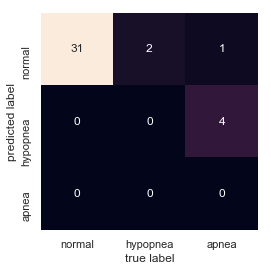

In [16]:
# confusion matrix 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

pre = svm_clf.predict(test_X)
mat = confusion_matrix(test_Y, pre)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
# plt.figure()
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.savefig("./cm_svm")
# plt.rcParams.update({'font.size': 40})
# plt.show()

### RandomForest

In [17]:
#print(clf.best_estimator_.get_params())
rf_clf = RandomForestClassifier(max_depth=20, max_features=0.7, criterion='gini', max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=2, n_estimators=10)
rf_clf.fit(train_X, train_Y)
test(rf_clf, test_X, test_Y)
rf_clf.feature_importances_

Total 38 events accuracy: 78.9 %
Total 7 abnormal accuracy: 0.0 %
normal 31 events accuracy: 96.8 %
hypopnea 2 events accuracy: 0.0 %
apnea 5 events accuracy: 0.0 % 

Precision_score: 69.9 
recall_score: 78.9 
f1_score: 74.2 


array([ 0.        ,  0.        ,  0.03930679,  0.05602027,  0.1242781 ,
        0.01275096,  0.00907853,  0.07234191,  0.03124365,  0.03332294,
        0.12156867,  0.        ,  0.00755508,  0.        ,  0.        ,
        0.03058606,  0.        ,  0.01456617,  0.00853175,  0.01706187,
        0.14321527,  0.01449302,  0.00590457,  0.02708594,  0.23108846])

### XGBoost

In [18]:
import xgboost as xgb
from xgboost import XGBClassifier

params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 3,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.1,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
}
plst = params.items()

dtrain = xgb.DMatrix(train_X, train_Y)
d_test_X = xgb.DMatrix(test_X)
# model = xgb.train(plst, dtrain, 100)

# test(model, d_test_X, test_Y)

xgb_clf = XGBClassifier(learning_rate=0.1)
xgb_clf.fit(np.array(train_X), train_Y)

test(xgb_clf, np.array(test_X), test_Y)
xgb_pred_train_score = xgb_clf.predict_proba(np.array(train_X))
xgb_pred_test_score = xgb_clf.predict_proba(np.array(test_X))

Total 38 events accuracy: 78.9 %
Total 7 abnormal accuracy: 0.0 %
normal 31 events accuracy: 96.8 %
hypopnea 2 events accuracy: 0.0 %
apnea 5 events accuracy: 0.0 % 



C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision_score: 74.2 
recall_score: 78.9 


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score: 76.5 


### LGB

In [19]:
train_data = lgb.Dataset(np.array(train_X), train_Y)
test_data = lgb.Dataset(np.array(test_X), label=test_Y)

params = {
    'task': 'train',
    'n_estimators': 30,
    'objective': 'multiclass',
    'max_depth': 50,
    'num_class': 3,
#     'metric': 'auc',
    'learning_rate': 0.1,
#     'verbose': 0
}

lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(train_X, train_Y)
# lgb_clf = lgb.train(params, train_data, valid_sets=test_data)

y_pred = lgb_clf.predict(test_X)
# y_pred = np.array([list(e).index(max(e)) for e in y_pred])

calc_accuracy(test_Y, y_pred)
lgb_pred_train_score = lgb_clf.predict_proba(train_X)
lgb_pred_test_score = lgb_clf.predict_proba(test_X)
# bst.save_model('model.txt')
# json_model = bst.dump_model()
# bst = lgb.Booster(model_file='model.txt')


Total 38 events accuracy: 73.7 %
Total 7 abnormal accuracy: 0.0 %
normal 31 events accuracy: 90.3 %
hypopnea 2 events accuracy: 0.0 %
apnea 5 events accuracy: 0.0 % 



C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision_score: 73.7 
recall_score: 73.7 


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score: 73.7 


### GBDT

In [21]:
gbdt_clf = GradientBoostingClassifier(random_state=10)
gbdt_clf.fit(train_X, train_Y)

test(gbdt_clf, test_X, test_Y)

gbdt_pred_train_score = gbdt_clf.predict_proba(train_X)
gbdt_pred_test_score = gbdt_clf.predict_proba(test_X)

Total 38 events accuracy: 81.6 %
Total 7 abnormal accuracy: 14.3 %
normal 31 events accuracy: 96.8 %
hypopnea 2 events accuracy: 0.0 %
apnea 5 events accuracy: 20.0 % 

Precision_score: 83.1 
recall_score: 81.6 
f1_score: 81.5 


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=1, p=5, metric='minkowski')
knn_clf.fit(train_X,train_Y)

test(knn, test_X, test_Y)

### Desicion Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=10)
dt_clf.fit(train_X, train_Y)

test(dt_clf, test_X, test_Y)

### Model fusion

#### 传统模型自我融合

In [ ]:
eclf = VotingClassifier(estimators=[('svm', svm_clf), ('lgb', lgb_clf), ('gbdt', gbdt_clf)])
eclf = eclf.fit(np.array(train_X),train_Y)
pre_Y = test(eclf, test_X, test_Y)

In [ ]:
# confusion matrix 
# test code for fusion models
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

pre = eclf.predict(test_X)
mat = confusion_matrix(test_Y, pre)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
# plt.figure()
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.savefig("./cm_svm")
# plt.rcParams.update({'font.size': 40})
# plt.show()

#### CNN和传统模型融合

In [ ]:
fusion_test_score = np.concatenate((svm_pred_test_score, cnn_pred_test_score), axis=1)
fusion_train_score = np.concatenate((svm_pred_train_score, cnn_pred_train_score), axis=1)
fusion_train_score = torch.from_numpy(fusion_train_score).float()
fusion_test_score = torch.from_numpy(fusion_test_score).float()
fusion_train_set = list(zip(fusion_train_score, train_Y))
fusion_test_set = list(zip(fusion_test_score, test_Y))

fusion_train_score.shape, fusion_test_score.shape,

In [ ]:
class fusion_network(nn.Module):
    def __init__(self):
        super(fusion_network,self).__init__()
        self.linear = nn.Linear(6,3)
    
    def forward(self, x):

        return self.linear(x)

#### train the fusion model

In [ ]:
fusion_train_loader = torch.utils.data.DataLoader(fusion_train_set, batch_size=batch_size, shuffle=True)
fusion_val_loader = torch.utils.data.DataLoader(fusion_test_set, batch_size=batch_size, shuffle=False)

In [ ]:
fusion_model = fusion_network()

fusion_criterion = torch.nn.CrossEntropyLoss()
fusion_optimizer = getattr(torch.optim, optim)(model.parameters(), lr=lr)
classes = ('normal', 'hypopnea', 'apnea')
best_acc = []

for ep in range(epochs):
    class_total = list(0. for i in range(3))
    class_correct = list(0. for i in range(3))
    train_loss = 0
    best_loss = 100
    for batch_idx, (data, target) in enumerate(fusion_train_loader):
        fusion_optimizer.zero_grad()
        if data.shape[0] == 1:
            continue
        output = fusion_model(data)
        loss = fusion_criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # validation
    numpy_Y = np.array([])
    numpy_pred = np.array([])
    for seqs, labels in fusion_val_loader:
        output = fusion_model(seqs)
        _,prediction = torch.max(output.data, 1)
        pre = (labels == prediction.data)
        numpy_Y = np.concatenate((numpy_Y, labels.numpy()))
        numpy_pred = np.concatenate((numpy_pred, prediction.numpy()))
        for y_i in range(len(labels)):
            label = labels[y_i]
            class_total[label] += 1
            class_correct[label] += pre[y_i].item()
            
    score(numpy_Y, numpy_pred)
    adjust_learning_rate(lr, fusion_optimizer, ep)
    accs = []
    accs.append("Accuracy of network on %d events: %.1f%%" %(sum(class_total),  sum(class_correct) / sum(class_total) *100))
    accs.append("Accuracy of network on %d abevents: %.1f%%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["Accuracy on %d %s events: %.1f%%" %(class_total[i], classes[i], class_correct[i] / class_total[i] * 100) for i in range(3)])

    train_loss = train_loss/(len(train_set))
    if train_loss < best_loss:
        best_loss = train_loss
        best_acc = accs
        torch.save(fusion_model.state_dict(), "./checkpoints/cnn_models/{}_params.pkl".format(str(fusion_model)[:3]))
        #log_model(model, optimizer, criterion, sum(class_total), best_loss, accs)
    epoch_str = ("Epoch {}. Train Loss: {}".format(ep, train_loss))
    print(epoch_str, "\n","\n".join(accs), "\n")
